<a href="https://colab.research.google.com/github/amkayhani/FAIDM/blob/main/Random_Forest_Battery_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regression: Random Forests for Battery Thickness Prediction**

## **Module Context**

This notebook is part of the Regression: Random Forests teaching module delivered at WMG, University of Warwick (January 2026).

## **Overview**

The aim of this notebook is to develop a Random Forest regression model to predict the Equivalent Full Cycles (EFCs) at a specified State of Health threshold (SOH = 0.9) for lithium-ion battery cells.

The model leverages charge–discharge profile characteristics extracted from early-life cycling data to estimate the cycle life of cells operating under diverse conditions. These include both laboratory-controlled test protocols and real-world electric vehicle (EV) usage profiles, highlighting the robustness of ensemble regression methods in practical energy-system applications.

## **Learning Objectives**

By the end of this notebook, students will be able to:
- understand the use of Random Forests for regression in battery health prediction,
- train and configure a Random Forest regressor,
- evaluate regression performance using appropriate metrics, and
- interpret model behaviour across different operating conditions.

## **Notebook Scope**

This notebook presents a complete and reproducible regression pipeline, including:
- feature extraction from charge–discharge profiles,
- definition of input variables and target EFC values,
- Random Forest model training and hyperparameter selection,
- performance evaluation and result interpretation.

## **Module Delivery**

Dr **Mona Faraji Niri** — Associate Professor of Energy Systems

Dr **Hamidreza Farhadi Tolie** — Research Fellow

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import skew, kurtosis
import os
import matplotlib.pyplot as plt

## 1. Data loading

In [ ]:
metadata_url = "https://drive.google.com/uc?id=10plwp_22mc2E5MnKhUSi1ZJBviWb-7E6"
features_url = "https://drive.google.com/uc?id=1_s0oQFlBhiSHRWs60iVX2RH5TulM533t"
target_url   = "https://drive.google.com/uc?id=15q2jV1B6no7a16tafTYt779z5GPM98FU"

# Load CSVs into DataFrames
df_features = pd.read_csv(features_url, index_col=0)
df_soh90    = pd.read_csv(target_url, index_col=0)

# Preview
df_features.head()


,Normalized Current Variance,Maximum Discharge Current,Relative Charge Fraction,Rest Fraction at High SOC,Rest SOC,Peak Frequency 1,Peak Frequency 2
Average Current,,,,,,,
0.060343,0.039616,0.101396,0.0,0.000000,0.086470,0.000018,0.000073
0.060326,0.039634,0.100298,0.0,0.000002,0.087134,0.000018,0.000073
0.060297,0.039663,0.100618,0.0,0.000000,0.500007,0.000037,0.000073
0.060288,0.039672,0.100760,0.0,0.000000,0.500006,0.000037,0.000073
0.060253,0.039707,0.100199,0.0,0.397227,1.000000,0.000018,0.000074


## 2. Train–Test Split

In [ ]:
X = df_features.values
y = np.array(df_soh90['EFCs (with Diagnostic)'])


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 3. Random Forest Model
**Hyper parameters of the model:**
- **n_estimators (default=100)** — Number of trees. More trees improve stability but increase training time. Example: 100, 500, 1000.
- **max_depth (default=None)** — Maximum depth of trees. Use None for fully grown trees, or smaller values to reduce overfitting. Example: None, 5, 10.
- **min_samples_split (default=2)** — Minimum samples to split a node. Larger values → more conservative trees. Example: 2, 5, 10.
- **min_samples_leaf (default=1)** — Minimum samples at a leaf. Larger values smooth predictions. Example: 1, 2, 4.
- **max_features (default="auto")** — Features considered at each split. Options: "sqrt", "log2", or integer number of features.
- **random_state** — Ensures reproducible results.
- **n_jobs** — CPU cores to use. -1 = all cores.

## Hyperparameter Optimisation with Random Forests and Validation Metrics

In this step, we perform hyperparameter optimisation for the Random Forest regressor using **Optuna**, while evaluating model performance on a validation set (X_test, y_test).

The goal is to find the combination of hyperparameters that maximises predictive performance (here measured by R²) for battery lifetime prediction, while also monitoring MAE and RMSE on the validation set.

**How it works:**

1. Optuna iteratively suggests hyperparameter combinations.
2. For each trial, the Random Forest is trained on X_train, y_train.
3. Predictions are made on X_test, and MAE, RMSE, and R² are calculated.
4. The progress bar shows optimisation progress, and trial results are printed in real-time.
5. At the end, the best parameter set is selected based on highest R², and final metrics are reported.

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Split dataset (if not already split)
# X_train, X_test, y_train, y_test

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 4),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        random_state=42,
        n_jobs=-1
    )

    # Train on training set
    rf.fit(X_train, y_train)

    # Predict on validation/test set
    y_pred = rf.predict(X_test)

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Log progress (trial number, R², MAE, RMSE)
    print(f"Trial {trial.number:03d} | R²: {r2:.3f} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | Params: {trial.params}")

    # Return R² to maximize
    return r2

# Create Optuna study
study = optuna.create_study(direction='maximize', study_name="RF_Validation_Optimisation")

# Optimize with progress bar
study.optimize(objective, n_trials=30, show_progress_bar=True)

# Best parameters and metrics
best_rf = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)
y_pred_best = best_rf.predict(X_test)

best_mae = mean_absolute_error(y_test, y_pred_best)
best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_r2 = r2_score(y_test, y_pred_best)

print("\n✅ Best Parameters Found:")
print(study.best_params)
print(f"MAE: {best_mae:.3f}, RMSE: {best_rmse:.3f}, R²: {best_r2:.3f}")


[I 2026-01-05 10:31:02,737] A new study created in memory with name: RF_Validation_Optimisation


  0%|          | 0/30 [00:00<?, ?it/s]

Trial 000 | R²: 0.776 | MAE: 35.309 | RMSE: 45.287 | Params: {'n_estimators': 486, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}
[I 2026-01-05 10:31:03,820] Trial 0 finished with value: 45.287372071120764 and parameters: {'n_estimators': 486, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 45.287372071120764.
Trial 001 | R²: 0.908 | MAE: 22.101 | RMSE: 28.992 | Params: {'n_estimators': 111, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
[I 2026-01-05 10:31:04,125] Trial 1 finished with value: 28.991556620722466 and parameters: {'n_estimators': 111, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 28.991556620722466.
Trial 002 | R²: 0.793 | MAE: 34.047 | RMSE: 43.480 | Params: {'n_estimators': 161, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_featu

In [ ]:
rf = RandomForestRegressor(
    n_estimators=354,
    max_depth=9,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=354,
                      n_jobs=-1, random_state=42)

## 4. Prediction and Evaluation

In [ ]:
y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(21.449653175353323, np.float64(28.50854351873446), 0.9110897762079663)

## 5. Visualisations

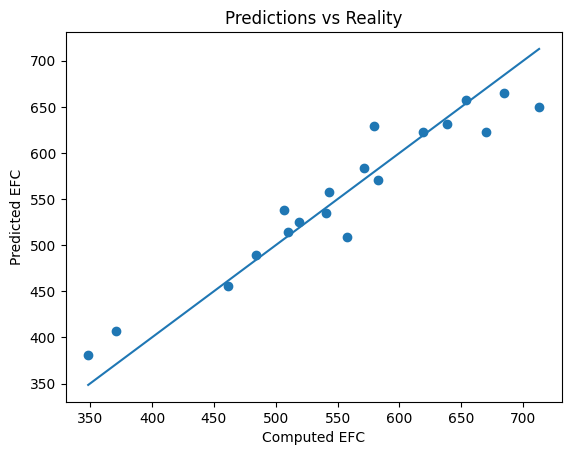

In [ ]:
plt.figure()
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Computed EFC")
plt.ylabel("Predicted EFC")
plt.title("Predictions vs Reality")
plt.show()

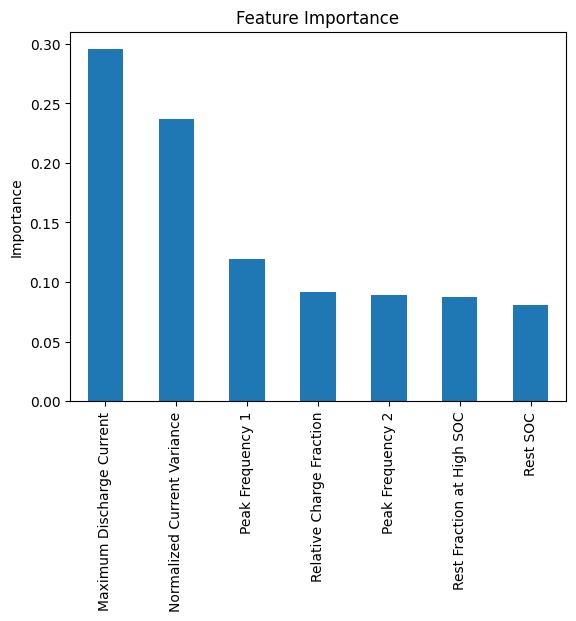

In [ ]:
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index= df_features.columns ).sort_values(ascending=False)

plt.figure()
feature_importance.plot(kind="bar")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()